In [ ]:
import cv2,os,time
os.sys.path.append('../utilities/')
from datetime import datetime
import numpy as np
import IPython.display as Disp
import support_utility_openvino
import matplotlib.pyplot as plt
import ipywidgets as widgets
from shapely.geometry import Polygon,Point

In [2]:
output_support = support_utility_openvino.create_plot()

In [3]:
face_model_path = "/media/prateek/shared_space/useful_models/openvino/face-detection-retail-0004/FP32/face-detection-retail-0004.xml"

face_reid_model = "/media/prateek/shared_space/useful_models/openvino/face-recognition-resnet34-arcface/model-r34-amf/openvino_model/face-recognition-resnet34-arcface.xml"
face_landmark_model = "/media/prateek/shared_space/useful_models/openvino/landmarks-regression-retail-0009/FP32/landmarks-regression-retail-0009.xml"

In [4]:
face_det = support_utility_openvino.async_infer()

face_det.load_model(face_model_path,"CPU")

Available Devices :  ['CPU', 'GNA', 'GPU']
OPTIMIZATION_CAPABILITIES for CPU:  ['FP32', 'FP16', 'INT8', 'BIN']
model inputs : dict_keys(['data'])
model outputs :  dict_keys(['detection_out'])


In [5]:
face_rec = support_utility_openvino.async_infer(ie_network=face_det.ie)

face_rec.load_model(face_reid_model,"CPU")

Available Devices :  ['CPU', 'GNA', 'GPU']
OPTIMIZATION_CAPABILITIES for CPU:  ['FP32', 'FP16', 'INT8', 'BIN']
model inputs : dict_keys(['data'])
model outputs :  dict_keys(['pre_fc1/Fused_Add_'])


In [6]:
face_landmark = support_utility_openvino.async_infer(ie_network=face_det.ie)
face_landmark.load_model(face_landmark_model,"CPU")

Available Devices :  ['CPU', 'GNA', 'GPU']
OPTIMIZATION_CAPABILITIES for CPU:  ['FP32', 'FP16', 'INT8', 'BIN']
model inputs : dict_keys(['0'])
model outputs :  dict_keys(['95'])


In [7]:
from tracker_1 import CentroidTracker
ct= CentroidTracker(maxDistance=100,minAppeared=1, maxDisappeared=5)

In [8]:
def normalize(array, axis):
    mean = array.mean(axis=axis)
    array -= mean
    std = array.std()
    array /= std
    return mean, std


def get_transform(src, dst):
    src_col_mean, src_col_std = normalize(src, axis=(0))
    dst_col_mean, dst_col_std = normalize(dst, axis=(0))

    u, _, vt = np.linalg.svd(np.matmul(src.T, dst))
    r = np.matmul(u, vt).T

    transform = np.empty((2, 3))
    transform[:, 0:2] = r * (dst_col_std / src_col_std)
    transform[:, 2] = dst_col_mean.T - \
        np.matmul(transform[:, 0:2], src_col_mean.T)
    return transform

def align_rois(face_images, face_landmarks):
    
    REFERENCE_LANDMARKS = [
        (30.2946 / 96, 51.6963 / 112), # left eye
        (65.5318 / 96, 51.5014 / 112), # right eye
        (48.0252 / 96, 71.7366 / 112), # nose tip
        (33.5493 / 96, 92.3655 / 112), # left lip corner
        (62.7299 / 96, 92.2041 / 112)]
    
    all_faces = []
    for image, image_landmarks in zip(face_images, face_landmarks):
        image = image.transpose((2,0,1))
        
        scale = np.array((image.shape[-1], image.shape[-2]))
        desired_landmarks = np.array(REFERENCE_LANDMARKS, dtype=np.float64) * scale
        landmarks = image_landmarks * scale

        transform = get_transform(desired_landmarks, landmarks)
        img = image.transpose((1, 2, 0))
        img = cv2.warpAffine(img.copy(), transform, tuple(scale), img,\
                           flags=cv2.WARP_INVERSE_MAP)
        img = img[0+5:img.shape[0]-5,0+5:img.shape[1]-5]
        
        all_faces.append(img)
    return all_faces


def merge_faces(aligned_faces,original_faces,face_size = (100,100)):
    original_faces_concat = np.concatenate([cv2.resize(face,face_size) for face in original_faces])
    aligned_faces_concat = np.concatenate([cv2.resize(face,face_size) for face in aligned_faces])
    merged_win = np.concatenate([original_faces_concat,aligned_faces_concat],axis=1)
    return merged_win

In [23]:
channel = "/media/prateek/shared_space/useful_vids/face_detection/202003211445.mp4"
# channel = 0
cap =  cv2.VideoCapture(channel)
thresh = .4
face_det.reinit_model()
face_rec.reinit_model()
face_landmark.reinit_model()
fps = []
embedding = []
while True:
    t1  = time.time()
    for i in range(4):
        ret, frame = cap.read()
    face_det.predict(frame)
    if face_det.frame_processed>=face_det.num_requests:
            frame,attr,res = face_det.postprocess_op()
            frame_op = output_support.label_obj_detection(frame,res[0],thresh=thresh,font_thickness=2)
            faces,bboxes = output_support.trim_frame_with_result(frame,res[0],threshold=thresh)
            
            objects = ct.update(bboxes)
                        # loop over the tracked objects
            for (objectID, centroid) in objects.items():
                # draw both the ID of the object and the centroid of the
                # object on the output frame
                text = "ID {}".format(objectID)
                cv2.putText(frame_op, text, (centroid[0] - 10, centroid[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                cv2.circle(frame_op, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
            
            landmarks = face_landmark.predict_batch_async(faces)
            landmarks = [np.array(out, dtype=np.float64).reshape(-1, 2) for out in landmarks]
            
            if len(faces)>0:
                aligned_faces = align_rois(np.copy(faces),landmarks)
                face_embedding = face_rec.predict_batch_async(aligned_faces)
    #             op = face_rec.predict_batch_async(faces) ## old code
                embedding.append(face_embedding)
                cv2.imshow("preview1",merge_faces(faces,aligned_faces))
            frame_op = output_support.write_text(frame_op,"FPS = %.4s"%(1/(time.time()-t1) ),text_color=(0,0,0))
            fps.append(1/(time.time()-t1))
            cv2.imshow("preview",frame_op)
            k = cv2.waitKey(1)
            if k==ord('q'):
                break
cap.release()
cv2.destroyAllWindows()


      

In [26]:
landmarks = face_landmark.predict_batch_async(faces)

In [28]:
landmarks = [np.array(out, dtype=np.float64).reshape(-1, 2) for out in landmarks]

In [64]:
align_rois(faces,landmarks)

[]

In [40]:
import pickle
pickle.dump(embedding,open("sequential_embedding.pickle","wb"))

In [41]:
del embedding

In [12]:
from scipy.optimize import linear_sum_assignment
import  scipy.spatial.distance as dist
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [46]:
for idx in range(len(embedding)-1):
    sim_mat = cosine_similarity(embedding[idx+1][0],embedding[idx][0])
    np.argmax(sim_mat,axis=1)
    break

In [12]:
dist.cosine(embedding[80][0][0],embedding[0][0][0])

0.0

In [50]:
D = cosine_similarity([i[0].flatten() for i in embedding[0]],[i[0].flatten() for i in embedding[1]])

In [56]:
 rows = D.max(axis=1).argsort()

In [57]:
rows

array([2, 0, 1])

In [58]:
cols = D.argmax(axis=1)[rows]

In [59]:
usedRows = set()
usedCols = set()

for (row, col) in zip(rows, cols):

    if row in usedRows or col in usedCols:
        continue

    if D[row, col] > self.maxDistance:
        continue

    objectID = objectIDs[row]
    self.objects[objectID] = inputCentroids[col]
    self.disappeared[objectID] = 0

    usedRows.add(row)
    usedCols.add(col)

array([0, 1, 0])

In [63]:
np.linalg.norm(embedding[3][0] - embedding[0][0], axis=1)

ValueError: operands could not be broadcast together with shapes (3,512) (2,512) 

In [17]:
import matplotlib.pyplot as plt

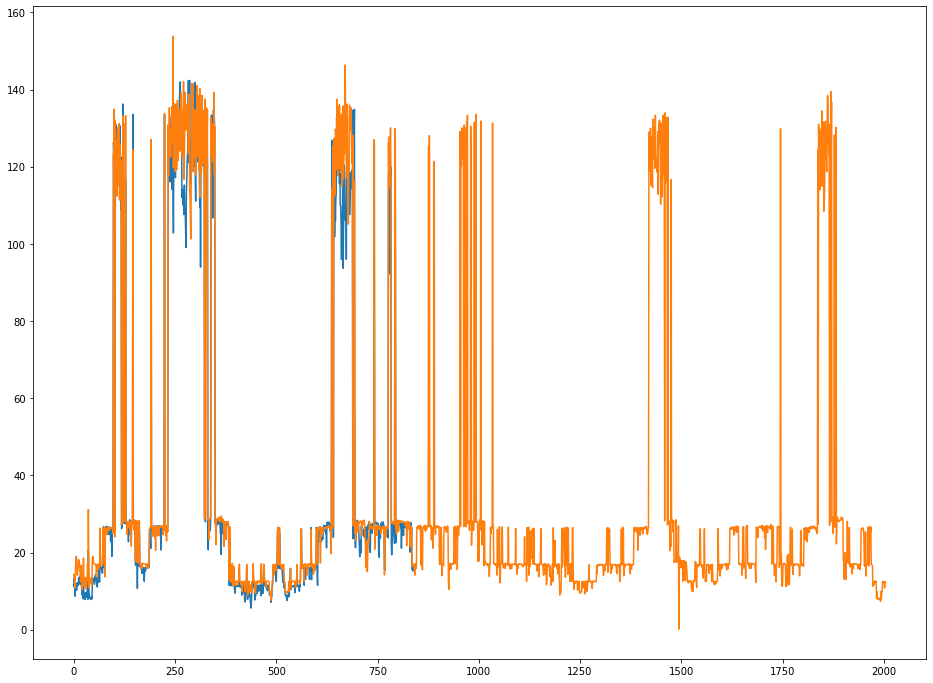

In [21]:
plt.figure(figsize=(16,12))
plt.plot(fps)
plt.plot(fps1)


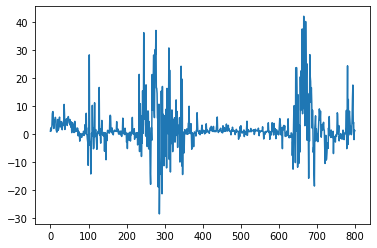

In [25]:
plt.plot(np.subtract(fps1[0:800],fps[0:800]))

In [8]:
(np.subtract(fps1[0:800],fps[0:800]).sum())/800

NameError: name 'fps1' is not defined

In [9]:
1685/800

2.10625

In [33]:
a = [1,2,3,4]
b = [12,13,44,11]

In [34]:
for idx,val in enumerate(zip(a,b)):
    print(val[0],val[1])

1 12
2 13
3 44
4 11


In [37]:
d = dict(zip(list(range(4)),list(zip(a,b))))

In [44]:
[i[0] for i in list(d.values())],[i[1] for i in list(d.values())]

([1, 2, 3, 4], [12, 13, 44, 11])

In [47]:
np.array(list(d.values()))[:]

array([[ 1, 12],
       [ 2, 13],
       [ 3, 44],
       [ 4, 11]])